## 🍃 End-to-End Multi class Tomato disease Classification

This notebook builds an end to end multi class classifier using Tensorflow 2.0 and tensorflow hub.

### 1. Problem
Identify the disease of the tomato leaf given an image of a tomato leaf.
It is made for farmers specially for agricultural purpose , 
as if any one wants to know about the disease which can happen to the plant in upcoming days
and one wants to stop it from happening.

### 2. Data
The data we are using is from REC Banda.

### 3. Evaluation
The Evaluation is a file with prediction probabilities for each disease of each test image.

### 4. Features
Some Information about the data

* We are dealing with images (unstructured data) so it's probably best we use deep/transfer learning .
*There are 10 Types of disease (This means there are 10 different classes).
*There are around 10,000 images in the training set.(These images have labels)
*There are around 1000 images in the validation set.


####  Total 10 Classes:   'Yellow_Leaf_Curl_Virus', 'Target_Spot', 'Spider_mites', 
####                                  'Septoria_leaf_spot', 'Mosaic_virus', 'Leaf_Mold', 'Late_blight', 
####                                  'Bacterial_spot', 'Early_blight', 'Healthy'


### 5. Goal 
To increase the Production and
To reduce the wastage of money and fertilizers.


In [24]:
# %tensorflow_version 1.x

import sys
import os
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import glob
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


img_size = 256

## Data Preprocessing 

 ### 1. While training the model we only use numerical data because the model finds similarities and learns from 
 ### numerical data only .
 ### 2. So we need to convert the labels too into numerical format .
 ### 3. We are assigning numbers to the classes of disease from 0-9 respectively to the 10 classes.

In [25]:
# load train and test dataset


# Creating X and Y lists to store  the Filnames and labels respectively
def prepare_data(path, img_size):
    X = []
    Y = []
    filenames = [img for img in glob.glob(path)]
    for i in tqdm(filenames):
        img = cv2.imread(i)
        img = cv2.resize(img, dsize=(img_size, img_size))
        X.append(img)
        split = i.split(os.sep)[-2]
#         print(split)

        # Assigning numbers to the classes of disease from 0-9 respectively to the 10 classes
        if split == "Tomato___Tomato_Yellow_Leaf_Curl_Virus":
            Y.append(0)
        elif split == "Tomato___Target_Spot":
            Y.append(1)
        elif split == "Tomato___Spider_mites Two-spotted_spider_mite":
            Y.append(2)
        elif split == "Tomato___Septoria_leaf_spot":
            Y.append(3)
        elif split == "Tomato___Tomato_mosaic_virus":
            Y.append(4)
        elif split == "Tomato___Leaf_Mold":
            Y.append(5)
        elif split == "Tomato___Late_blight":
            Y.append(6)
        elif split == "Tomato___Bacterial_spot":
            Y.append(7)
        elif split == "Tomato___Early_blight":
            Y.append(8)
        elif split == "Tomato___healthy":
            Y.append(9)  
    X = np.asarray(X)
    return X, Y

### Calling the prepare_data function

In [27]:
# Loading the train dataSet from the internal storage of pc
x_train, y_train = prepare_data(r'D:\Tomato_disease\model01\dataset\train\*\*', img_size)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.40it/s]


In [28]:
print(len(y_train))

1000


In [29]:
# Loading the validation dataSet from the internal storage of pc
x_val, y_val = prepare_data(r'D:\Tomato_disease\model01\dataset\val\*\*', img_size)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1053.77it/s]


In [9]:
print("x_train in MBs:", x_train.nbytes/(1024*1024))
print("x_val in MBs:", x_val.nbytes/(1024*1024))

x_train in MBs: 187.5
x_val in MBs: 37.5


In [10]:
on_save = 1
on_load = 1

### Saving the images in numpy array format so that we can use it later directly

In [12]:
from numpy import save

if on_save == 1:
  save(r'D:\Tomato_disease\model01\saved_arrays\tomato\trainX_'+str(img_size)+'.npy', x_train)
  save(r'D:\Tomato_disease\model01\saved_arrays\tomato\trainY_'+str(img_size)+'.npy', y_train)
  save(r'D:\Tomato_disease\model01\saved_arrays\tomato\valX_'+str(img_size)+'.npy', x_val)
  save(r'D:\Tomato_disease\model01\saved_arrays\tomato\valY_'+str(img_size)+'.npy', y_val)


In [14]:
from numpy import load

if on_load == 1:
  train_x = load(r'D:\Tomato_disease\model01\saved_arrays\tomato\trainX_'+str(img_size)+'.npy')
  train_y = load(r'D:\Tomato_disease\model01\saved_arrays\tomato\trainY_'+str(img_size)+'.npy')
  val_x   = load(r'D:\Tomato_disease\model01\saved_arrays\tomato\valX_'+str(img_size)+'.npy')
  val_y   = load(r'D:\Tomato_disease\model01\saved_arrays\tomato\valY_'+str(img_size)+'.npy')

### Normalizing images , to increase the rate of learning process by decreasing the size.

In [15]:
# Scale up the pixels

def prep_pixels(trainX, valX):
	train_norm = trainX.astype('float32')
	val_norm = valX.astype('float32')

	train_norm = train_norm / 255.0
	val_norm = val_norm / 255.0

	return train_norm, val_norm

### Converting labels into categorical dtype as it has a numerical assigned value at backend against each class.

In [19]:
trainX, valX = prep_pixels(train_x, val_x)

# Hot Encoding
print(train_y)
print(val_y)
trainY = to_categorical(train_y)
valY = to_categorical(val_y) #important
print(trainY)
print(valY)


[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 

In [21]:
# print(trainX.shape)
print(train_y.shape)
print(trainY.shape)

# print(valX.shape)
# print(valY.shape)

(1000,)
(1000, 10)


In [22]:
print("Memory size of a NumPy array in GBs:", trainX.nbytes/(1024*1024*1024))

Memory size of a NumPy array in GBs: 0.732421875


## Defining the `Alex-net` Archietecture by the arrangement of CNN Layers
AlexNet was the first convolutional network which used GPU to boost performance. 

1.      AlexNet architecture consists of 5 convolutional layers, 3 max-pooling layers, 2 normalization layers, 2 fully connected         layers, and 1 softmax layer. 

        **The ReLU function is a non-linear activation function. 
        Activation function decides whether the neuron should be activated or not.
        The main advantage of using the ReLU function over other activation functions is that it does not activate all                   the neurons at the same time.**
        

2.      Each convolutional layer consists of convolutional filters and a nonlinear activation function ReLU. 

3.      The pooling layers are used to perform max pooling. 

4.      Input size is fixed due to the presence of fully connected layers.

## Keras Conv2D :
It is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.

1. `kernel_size`  : This parameter determines the dimensions of the kernel. Common dimensions include 1×1, 3×3, 5×5, and 7×7 which can be passed as (1, 1), (3, 3), (5, 5), or (7, 7) tuples.
It is an integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
This parameter must be an odd integer.


2. `activation` : The activation parameter to the Conv2D class is simply a convenience parameter which allows you to supply a string, which specifies the name of the activation function you want to apply after performing the convolution.


3. `kernel_initializer` :This parameter controls the initialization method which is used to initialize all the values in the Conv2D class before actually training the model.
It is the initializer for the kernel weights matrix.


4. `padding` : The padding parameter of the Keras Conv2D class can take one of two values: ‘valid’ or ‘same’.
Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.
You can instead preserve spatial dimensions of the volume such that the output volume size matches the input volume size, by setting the value to the “same”.


## Keras MaxPooling2D :
Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map.


` pool_size ` : integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window. If only one integer is specified, the same window length will be used for both dimensions.

## Flatten() : 
Flattening is used to convert all the resultant 2-Dimensional arrays from pooled feature maps into a single long continuous linear vector. 

## Dense Layer ():
Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer, thus called as dense. Dense Layer is used to classify image based on output from convolutional layers. Working of single neuron. A layer contains multiple number of such neurons.

**kernel_initializer:** Initializer for the kernel weights matrix.

**units:** Positive integer, dimensionality of the output space.

**Softmax function :** Softmax function use in last output layer. Dense Layer is used to classify image based on output from convolutional layers. *Dense Layer is used to classify image based on output from convolutional layers.*

In [47]:
#@title Default title text
# define cnn model
def define_model():
	kernel = (3, 3) #
	first_conv  = 32
	second_conv = first_conv * 2
	third_conv  = second_conv * 2

	model = Sequential()
	model.add(Conv2D(first_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_size, img_size, 3)))
	model.add(BatchNormalization())
	
	model.add(Conv2D(first_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	
	model.add(Dropout(0.2))
	model.add(Conv2D(second_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	
	model.add(Conv2D(second_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	
	model.add(Dropout(0.3))
	model.add(Conv2D(third_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	
	model.add(Conv2D(third_conv, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	
	model.add(Dropout(0.4))
	model.add(Flatten())
 
	model.add(Dense(third_conv, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
 
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
 
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	model.summary()
	return model

# define model
model = define_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)     

In [48]:
# datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# it_train = datagen.flow(trainX, trainY, batch_size = 5)

### Assigning the path of the trained model and its label and passing it to the `ModelCheckpoint` function

In [49]:
pathModelSave = r'C:\Users\User\Desktop\tomato-disease-prediction\model01\SavedModels\tomato_'+str(img_size)+'.hdf5'
pathToSaveCSV = r'C:\Users\User\Desktop\tomato-disease-prediction\model01\SavedModels\csv\tomato_'+str(img_size)+'.csv'

## ModelCheckpoint :  

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

1. `filepath`: string or PathLike, path to save the model file.


2. `monitor` : The metric name to monitor.


3. `verbose` : Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.


4. `save_best_only` : if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. 
save_weights_only: if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).


5. `mode` : one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' and are set to min for the rest of the quantities.



## Model.fit():

1. `trainX,trainY` : Passing the training data and it's label


2. `batch_size` : If we are try to process 10,000+ images in one go... they all might not fit into the memory.So that's why we do about 32 images at a time.


3. `epoch` : An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed. **If the batch size is the whole training dataset then the number of epochs is the number of iterations.**


4. `validation_data` : Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. 


5. `use_multiprocessing` : Implementation relies on multiprocessing.


6. `verbose:` Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.

## CSVLogger() :

Callback that streams epoch results to a CSV file.

1. `filename`: Filename of the CSV file, e.g. 'run/log.csv'.

2. `separator`: String used to separate elements in the CSV file.

3. `append`: Boolean. True: append if file exists (useful for continuing training). False: overwrite existing file.

In [18]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(pathModelSave, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

csv_logger = CSVLogger(pathToSaveCSV, append=False, separator=',')

start = datetime.now()

steps = int(trainX.shape[0] / 32)

history = model.fit(
          trainX, trainY,
          batch_size= 32, 
          epochs= 10,
          callbacks = [checkpoint, csv_logger],
          validation_data = (valX, valY),
          use_multiprocessing = True,
          verbose=1)

duration = datetime.now() - start

print("Total training time is:", duration)

Epoch 1/10
63/63 [==============================] - 42s 347ms/step - loss: 2.2657 - accuracy: 0.3007 - val_loss: 3.8750 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to C:\Users\User\Desktop\tomato-disease-prediction\model01\SavedModels\tomato_256.hdf5
Epoch 2/10
63/63 [==============================] - 18s 292ms/step - loss: 1.3290 - accuracy: 0.5524 - val_loss: 2.7770 - val_accuracy: 0.1100

Epoch 00002: val_accuracy improved from 0.10000 to 0.11000, saving model to C:\Users\User\Desktop\tomato-disease-prediction\model01\SavedModels\tomato_256.hdf5
Epoch 3/10
63/63 [==============================] - 18s 292ms/step - loss: 0.8276 - accuracy: 0.7546 - val_loss: 3.3518 - val_accuracy: 0.1400

Epoch 00003: val_accuracy improved from 0.11000 to 0.14000, saving model to C:\Users\User\Desktop\tomato-disease-prediction\model01\SavedModels\tomato_256.hdf5
Epoch 4/10
63/63 [==============================] - 18s 293ms/step - loss: 0.6538 - accurac

## Model Evaluation
Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data. Keras model provides a function, evaluate which does the evaluation of the model.

It has three main arguments:

`Test data`

`Test data label`

`verbose - true or false`

In [19]:
# evaluate model
_, acc = model.evaluate(valX, valY, verbose=0)
print('without model loading, validation acc is> %.3f' % (acc * 100.0))

without model loading, validation acc is> 57.000


In [20]:
import tensorflow as tf

gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

print("gpu_options:", gpu_options)
print("session:", session)

new_model = load_model(pathModelSave)
_, acc_train = new_model.evaluate(trainX, trainY, verbose=1)
print('training acc is> %.3f' % (acc_train * 100.0))

gpu_options: allow_growth: true

session: <tensorflow.python.client.session.InteractiveSession object at 0x0000020CFA65F2B0>
32/32 [==============================] - 4s 125ms/step - loss: 0.7854 - accuracy: 0.7900
training acc is> 79.000


In [21]:
_val, acc_val = new_model.evaluate(valX, valY, verbose=0)
print('validation acc is> %.3f' % (acc_val * 100.0))

validation acc is> 57.000


(256, 256, 3)


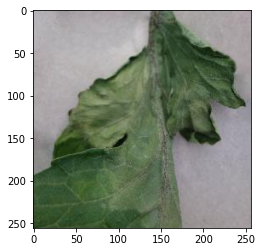

In [22]:
# it is used in below intermediate visualization

path_healthy = r'C:\Users\User\Desktop\tomato-disease-prediction\model01\dataset\train\Tomato___Late_blight\973b8b82-cccd-433c-a868-5dee559b2dce___GHLB Leaf 2.6 Day 12.JPG'
img_vis = cv2.imread(path_healthy)
img_vis = cv2.resize(img_vis, dsize=(img_size, img_size))
img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
# plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.imshow(img_vis)
print(img_vis.shape)

In [23]:
model = load_model(pathModelSave)

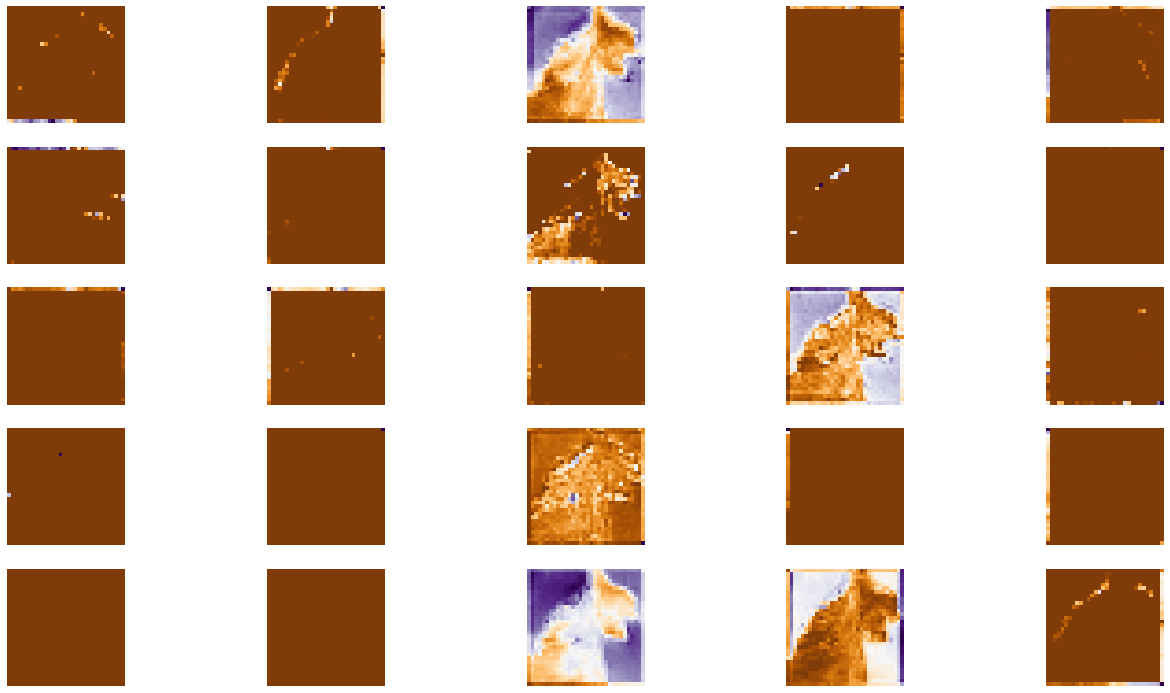

In [24]:
# It is for intermediate conv2d layers visualization
from tensorflow.keras.models import Model

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs = model.input, outputs=layer_outputs)
activations = activation_model.predict(img_vis.reshape(1,img_size,img_size,3))

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*4.5, col_size*2.5)) # sharex=True, sharey=True
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0][:, :, activation_index], cmap='PuOr')
            ax[row,col].axis('off')
            activation_index += 1

display_activation(activations, 5, 5, 17)

In [27]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.show()

  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.show()
  
  # save plot to file
  # filename = sys.argv[0].split('/')[-1]
  # pyplot.savefig(filename + '_plot.png')
  # pyplot.close()

  plt.plot(history.history["accuracy"])
  plt.plot(history.history['val_accuracy'])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("model accuracy")

  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation Loss"])
  plt.show()

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
  plt.show()


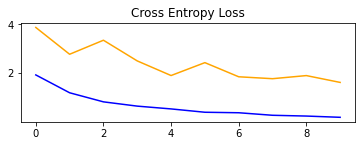

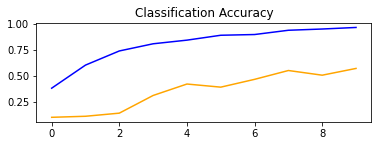

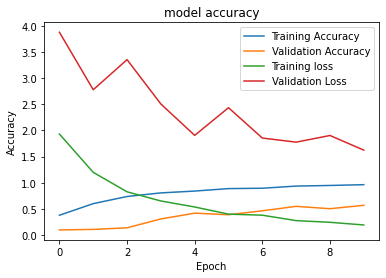

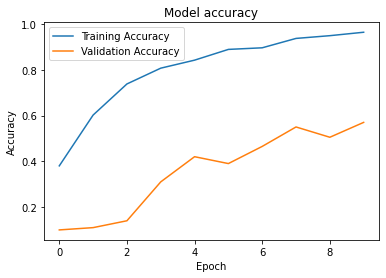

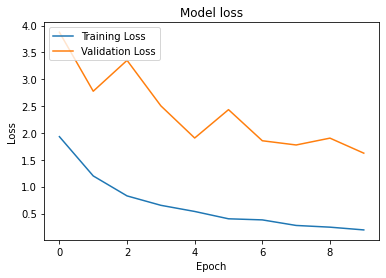

In [28]:
# learning curves
summarize_diagnostics(history)

In [29]:
# this is the new prediction function <optimized> to calcultae prediction time per image
model = load_model(pathModelSave)

def new_prediction_fun(path):
  filenames = [img for img in glob.glob(path + '/*')]
  count = 0
  total_time = 0
  YLCV, TS, SM, SLS, MV, LM, LB, BS, EB, H = 0,0,0,0,0,0,0,0,0,0
  for i in filenames:
      count += 1
      tic = time.clock()
      img = cv2.imread(i)
      img = cv2.resize(img, dsize=(img_size, img_size))
      img = img.astype('float32')
      img = img / 255.0
      img = img[np.newaxis, :]
      p = model.predict(img)[0]
      max_val_index = p.argmax()
      toc = time.clock()
      time_t = toc-tic
      
      if (max_val_index == 0):
        YLCV += 1
      elif (max_val_index == 1):
        TS += 1
      elif (max_val_index == 2):
        SM += 1
      elif (max_val_index == 3):
        SLS += 1
      elif (max_val_index == 4):
        MV += 1
      elif (max_val_index == 5):
        LM += 1
      elif (max_val_index == 6):
        LB += 1
      elif (max_val_index == 7):
        BS += 1
      elif (max_val_index == 8):
        EB += 1
      elif (max_val_index == 9):
        H += 1  
      
    
      total_time += time_t
  
  print("\n")    
  print("Total prediction time for "+str(count)+" images is: ", total_time, "sec")
  print("Average prediction time is:", total_time/count, "sec")
  
  print("\n")
  print("YLCV predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", YLCV)
  print("TS predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", TS)
  print("SM predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", SM)
  print("SLS predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", SLS)
  print("MV predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", MV)
  print("LM predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", LM)
  print("LB predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", LB)
  print("BS predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", BS)
  print("EB predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", EB)
  print("H predictions out of total "+str(count)+" "+str(os.path.split(path)[1])+" images are: ", H)

In [30]:
# augumented testing, more images
new_prediction_fun(r'C:\Users\User\Desktop\tomato-disease-prediction\model01\dataset\train\Tomato___Late_blight')



Total prediction time for 100 images is:  3.2857305999999866 sec
Average prediction time is: 0.032857305999999864 sec


YLCV predictions out of total 100 Tomato___Late_blight images are:  0
TS predictions out of total 100 Tomato___Late_blight images are:  0
SM predictions out of total 100 Tomato___Late_blight images are:  14
SLS predictions out of total 100 Tomato___Late_blight images are:  0
MV predictions out of total 100 Tomato___Late_blight images are:  0
LM predictions out of total 100 Tomato___Late_blight images are:  1
LB predictions out of total 100 Tomato___Late_blight images are:  82
BS predictions out of total 100 Tomato___Late_blight images are:  0
EB predictions out of total 100 Tomato___Late_blight images are:  0
H predictions out of total 100 Tomato___Late_blight images are:  3


In [31]:
print(type(history))
...
# list all data in history
print(history.history.keys())

<class 'tensorflow.python.keras.callbacks.History'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [32]:
print(history.history['loss'])

[1.9307966232299805, 1.1996008157730103, 0.8275918960571289, 0.652454137802124, 0.53800368309021, 0.401483416557312, 0.38106343150138855, 0.27751216292381287, 0.24555420875549316, 0.19436663389205933]


In [33]:
print(history.history['val_loss'])

[3.8749911785125732, 2.7769505977630615, 3.3517708778381348, 2.5045533180236816, 1.9055702686309814, 2.4337804317474365, 1.8545204401016235, 1.7759618759155273, 1.903344750404358, 1.6235007047653198]


In [34]:
print(history.history['accuracy'])

[0.3799999952316284, 0.6019999980926514, 0.7379999756813049, 0.8069999814033508, 0.8420000076293945, 0.8889999985694885, 0.8960000276565552, 0.9369999766349792, 0.9490000009536743, 0.9639999866485596]


In [35]:
print(history.history['val_accuracy'])

[0.10000000149011612, 0.10999999940395355, 0.14000000059604645, 0.3100000023841858, 0.41999998688697815, 0.38999998569488525, 0.4650000035762787, 0.550000011920929, 0.5049999952316284, 0.5699999928474426]
